In [1]:
## Megan getting errors with Yoni script src folder 
# copy and pasting functions here 

# script goal - use mediapipe world outputs to estimate depth in meters 

In [2]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

In [3]:
#from src.analysis_funs import get_landmark_pairs, get_all_unique_pairs
def get_all_unique_pairs(df):
    df_pairs = df.merge(df, on='frame', how='left')
    df_pairs = df_pairs[df_pairs['label_x'] != df_pairs['label_y']]
    def make_id(x, y, i):
        return str(i) + "-" +  str(max(x,y)) + "-" + str(min(x,y))
    df_pairs["row_id"] = df_pairs.apply(lambda row: make_id(row["subframe_id_x"],
                                                                row["subframe_id_y"],
                                                                row["frame"]), axis=1)
    return df_pairs.drop_duplicates(subset="row_id", keep="first")


def get_landmark_pairs(landmark_df, label_x, label_y):
    tmp = landmark_df.merge(landmark_df, on='frame', how='left')
    return tmp[(tmp.label_x == label_x) & (tmp.label_y == label_y)].copy()

In [4]:
output_path = r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\test_velocity_01302025\hc_video_output\NW_HC\2024-05-02\000_raw_pose_data'
csv_file_name = 'mari_mpipe_gait_vertical_left_df.csv'
png_file_name = 'mari_mpipe_gait_vertical_left_df.png'

mpipe_path = r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\test_velocity_01302025\hc_video_output\NW_HC\2024-05-02\000_raw_pose_data\gait_vertical_left_mediapipe_world.csv'
mari_path = r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\test_velocity_01302025\hc_video_output\NW_HC\2024-05-02\000_raw_pose_data\gait_vertical_left_marigold.csv'
yolo_path = r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\test_velocity_01302025\hc_video_output\NW_HC\2024-05-02\000_raw_pose_data\gait_vertical_left_yolo.csv'

## Calculate hip width as true distance change

In [5]:
# hip width in pixels 
yolo_df = pd.read_csv(yolo_path, index_col = 0) 
r_hip_yolo_df = yolo_df.loc[yolo_df['label'] == 'right_hip']
r_hip_yolo_df.set_index('frame', inplace=True)
l_hip_yolo_df = yolo_df.loc[yolo_df['label'] == 'left_hip']
l_hip_yolo_df.set_index('frame', inplace=True)
r_hip_yolo_df.head()

l_hip_yolo_df = l_hip_yolo_df.copy()
l_hip_yolo_df.loc[:, 'hip_width_x'] = abs(r_hip_yolo_df['X'] - l_hip_yolo_df['X']).rolling(window=10, min_periods = 1).mean()

l_hip_yolo_df.head()

,X,Y,label,hip_width_x
frame,,,,
0,713.57776,713.86096,left_hip,395.820440
1,714.31274,714.39355,left_hip,395.290790
2,714.21120,718.15430,left_hip,395.063517
3,711.06190,715.53330,left_hip,394.488047
4,714.55780,715.23890,left_hip,394.931158


## Create meters/depth conversion ratio 

In [6]:
# mediapipe world landmarks 
mpipe = pd.read_csv(mpipe_path)

mpipe = mpipe.rename(columns={'Unnamed: 0': 'subframe_id'})
mpipe_filt = mpipe[mpipe['label'].notnull()]

mpipe_pairs = get_all_unique_pairs(mpipe_filt)
mpipe_pairs.head()

,subframe_id_x,X_x,Y_x,Z_x,vis_x,pres_x,frame,label_x,subframe_id_y,X_y,Y_y,Z_y,vis_y,pres_y,label_y,row_id
1,0,0.25516,-0.281958,-0.452927,0.915724,0.0,0,nose,1,0.230257,-0.290935,-0.474691,0.947618,0.0,left_eye_inner,0-1-0
2,0,0.25516,-0.281958,-0.452927,0.915724,0.0,0,nose,2,0.230838,-0.291485,-0.473776,0.945280,0.0,left_eye,0-2-0
3,0,0.25516,-0.281958,-0.452927,0.915724,0.0,0,nose,3,0.230315,-0.291497,-0.473565,0.951135,0.0,left_eye_outer,0-3-0
4,0,0.25516,-0.281958,-0.452927,0.915724,0.0,0,nose,4,0.239321,-0.268998,-0.481281,0.939452,0.0,right_eye_inner,0-4-0
5,0,0.25516,-0.281958,-0.452927,0.915724,0.0,0,nose,5,0.239435,-0.269174,-0.482445,0.933815,0.0,right_eye,0-5-0


In [7]:
# marigold depth estimates 
mari = pd.read_csv(mari_path)

mari = mari.rename(columns={'Unnamed: 0': 'subframe_id'})
mari_filt = mari[mari['label'].notnull()]

mari_pairs = get_all_unique_pairs(mari_filt)
mari_pairs.head()

,subframe_id_x,frame,label_x,depth_est_x,subframe_id_y,label_y,depth_est_y,row_id
1,0,0,nose,0.252929,1,left_eye_inner,0.251347,0-1-0
2,0,0,nose,0.252929,2,left_eye,0.250893,0-2-0
3,0,0,nose,0.252929,3,left_eye_outer,0.250047,0-3-0
4,0,0,nose,0.252929,4,right_eye_inner,0.252093,0-4-0
5,0,0,nose,0.252929,5,right_eye,0.252751,0-5-0


In [8]:
# merge marigold and mediapipe pairs 
mari_mpipe = mari_pairs.merge(mpipe_pairs, on=['frame', 'row_id'])
print(f"mari_pipe type: {type(mari_mpipe)}")
mari_mpipe.head()

mari_pipe type: <class 'pandas.core.frame.DataFrame'>


,subframe_id_x_x,frame,label_x_x,depth_est_x,subframe_id_y_x,label_y_x,depth_est_y,row_id,subframe_id_x_y,X_x,...,vis_x,pres_x,label_x_y,subframe_id_y_y,X_y,Y_y,Z_y,vis_y,pres_y,label_y_y
0,0,0,nose,0.252929,1,left_eye_inner,0.251347,0-1-0,0,0.25516,...,0.915724,0.0,nose,1,0.230257,-0.290935,-0.474691,0.947618,0.0,left_eye_inner
1,0,0,nose,0.252929,2,left_eye,0.250893,0-2-0,0,0.25516,...,0.915724,0.0,nose,2,0.230838,-0.291485,-0.473776,0.945280,0.0,left_eye
2,0,0,nose,0.252929,3,left_eye_outer,0.250047,0-3-0,0,0.25516,...,0.915724,0.0,nose,3,0.230315,-0.291497,-0.473565,0.951135,0.0,left_eye_outer
3,0,0,nose,0.252929,4,right_eye_inner,0.252093,0-4-0,0,0.25516,...,0.915724,0.0,nose,4,0.239321,-0.268998,-0.481281,0.939452,0.0,right_eye_inner
4,0,0,nose,0.252929,5,right_eye,0.252751,0-5-0,0,0.25516,...,0.915724,0.0,nose,5,0.239435,-0.269174,-0.482445,0.933815,0.0,right_eye


In [9]:
def check_row(labxx,labyx,labxy,labyy):
    return (labxx == labxy) and (labyx == labyy)


mari_mpipe["label_agreement"] = mari_mpipe.apply(lambda row: check_row(row["label_x_x"],
                                                                       row["label_y_x"],
                                                                       row["label_x_y"],
                                                                       row["label_y_y"]),
                                                 axis=1)
mari_mpipe.head()

,subframe_id_x_x,frame,label_x_x,depth_est_x,subframe_id_y_x,label_y_x,depth_est_y,row_id,subframe_id_x_y,X_x,...,pres_x,label_x_y,subframe_id_y_y,X_y,Y_y,Z_y,vis_y,pres_y,label_y_y,label_agreement
0,0,0,nose,0.252929,1,left_eye_inner,0.251347,0-1-0,0,0.25516,...,0.0,nose,1,0.230257,-0.290935,-0.474691,0.947618,0.0,left_eye_inner,True
1,0,0,nose,0.252929,2,left_eye,0.250893,0-2-0,0,0.25516,...,0.0,nose,2,0.230838,-0.291485,-0.473776,0.945280,0.0,left_eye,True
2,0,0,nose,0.252929,3,left_eye_outer,0.250047,0-3-0,0,0.25516,...,0.0,nose,3,0.230315,-0.291497,-0.473565,0.951135,0.0,left_eye_outer,True
3,0,0,nose,0.252929,4,right_eye_inner,0.252093,0-4-0,0,0.25516,...,0.0,nose,4,0.239321,-0.268998,-0.481281,0.939452,0.0,right_eye_inner,True
4,0,0,nose,0.252929,5,right_eye,0.252751,0-5-0,0,0.25516,...,0.0,nose,5,0.239435,-0.269174,-0.482445,0.933815,0.0,right_eye,True


In [10]:
# depth_to_m: conversion of mediapipe Z depth / marigold depth est 
# for each row: (mediapipe Z world distance between the two landmarks) / (marigold depth diff between the two landmarks) 
mari_mpipe["depth_to_m"] = np.abs(mari_mpipe["Z_x"] - mari_mpipe["Z_y"]) / np.abs(mari_mpipe["depth_est_x"] - mari_mpipe["depth_est_y"])
mari_mpipe.head()

,subframe_id_x_x,frame,label_x_x,depth_est_x,subframe_id_y_x,label_y_x,depth_est_y,row_id,subframe_id_x_y,X_x,...,label_x_y,subframe_id_y_y,X_y,Y_y,Z_y,vis_y,pres_y,label_y_y,label_agreement,depth_to_m
0,0,0,nose,0.252929,1,left_eye_inner,0.251347,0-1-0,0,0.25516,...,nose,1,0.230257,-0.290935,-0.474691,0.947618,0.0,left_eye_inner,True,13.760708
1,0,0,nose,0.252929,2,left_eye,0.250893,0-2-0,0,0.25516,...,nose,2,0.230838,-0.291485,-0.473776,0.945280,0.0,left_eye,True,10.244293
2,0,0,nose,0.252929,3,left_eye_outer,0.250047,0-3-0,0,0.25516,...,nose,3,0.230315,-0.291497,-0.473565,0.951135,0.0,left_eye_outer,True,7.162402
3,0,0,nose,0.252929,4,right_eye_inner,0.252093,0-4-0,0,0.25516,...,nose,4,0.239321,-0.268998,-0.481281,0.939452,0.0,right_eye_inner,True,33.925724
4,0,0,nose,0.252929,5,right_eye,0.252751,0-5-0,0,0.25516,...,nose,5,0.239435,-0.269174,-0.482445,0.933815,0.0,right_eye,True,166.131667


In [11]:
mari_mpipe.to_csv(os.path.join(output_path, csv_file_name)) 

In [12]:
# median 
convert_depth = mari_mpipe.groupby(['frame'])['depth_to_m'].median()
convert_depth_df = pd.DataFrame(convert_depth)
convert_depth_df = convert_depth_df.rename(columns = {'depth_to_m' : 'median_depth_to_m'})

## on same axis as depth_to_m --> smooth depth_to_m

In [13]:
convert_depth_df['smoothed_median_depth_to_m'] = convert_depth_df['median_depth_to_m'].rolling(window=3, min_periods = 1).mean()
convert_depth_df.head()

,median_depth_to_m,smoothed_median_depth_to_m
frame,,
0,11.861838,11.861838
30,1.719662,6.790750
90,9.598371,7.726624
120,3.203911,4.840648
150,2.791151,5.197811


## Estimate depth = (marigold depth median of all landmarks) * (smoothed - depth_to_m - median at each frame) 

In [14]:
#median depth estimate for each frame 
convert_depth_df['median_mari_depth_est'] = mari_mpipe.groupby(['frame'])['depth_est_x'].median()
convert_depth_df.head()

convert_depth_df['meter_depth_est'] = convert_depth_df['median_mari_depth_est'] * convert_depth_df['median_depth_to_m']
convert_depth_df['meter_depth_est_smooth'] = convert_depth_df['median_mari_depth_est'] * convert_depth_df['smoothed_median_depth_to_m']

convert_depth_df.head()

,median_depth_to_m,smoothed_median_depth_to_m,median_mari_depth_est,meter_depth_est,meter_depth_est_smooth
frame,,,,,
0,11.861838,11.861838,0.252929,3.000198,3.000198
30,1.719662,6.790750,0.064166,0.110344,0.435735
90,9.598371,7.726624,0.067842,0.651176,0.524192
120,3.203911,4.840648,0.189871,0.608329,0.919098
150,2.791151,5.197811,0.399129,1.114030,2.074599


In [15]:
# raw 
print(f"max feet depth est: {convert_depth_df['meter_depth_est'].max() * 3.28}")
print(f"min feet depth est: {convert_depth_df['meter_depth_est'].min() * 3.28}")

# smoothed 
print('smoothed') 
print(f"max feet depth est: {convert_depth_df['meter_depth_est_smooth'].max() * 3.28}")
print(f"min feet depth est: {convert_depth_df['meter_depth_est_smooth'].min() * 3.28}")

max feet depth est: 12.718998582094098
min feet depth est: 0.0006228245311553723
smoothed
max feet depth est: 11.282132583861275
min feet depth est: 0.04014827543718796


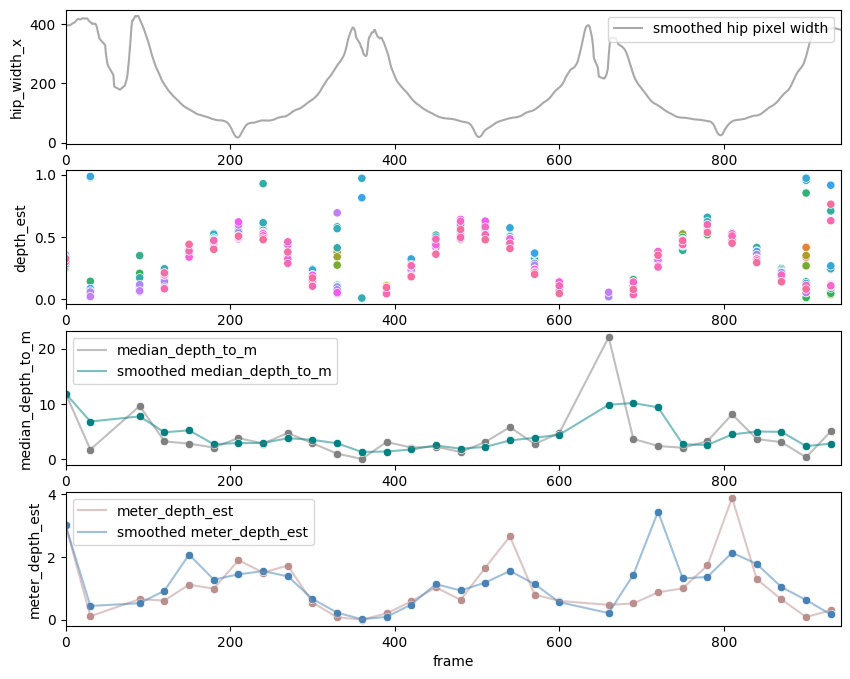

In [16]:
# plot 
max_frame = yolo_df['frame'].max()

fig, axs = plt.subplots(4, 1, figsize=(10, 8))
# hip width data 
sns.lineplot(x = 'frame', y = 'hip_width_x', data = l_hip_yolo_df, color = 'darkgrey', label = 'smoothed hip pixel width', ax = axs[0])
axs[0].legend(loc = 'upper right')
axs[0].set_xlim(0, max_frame) 

# raw depth data 
sns.scatterplot(x = 'frame', y = 'depth_est', hue = 'label', data = mari, ax = axs[1], legend = False)
axs[1].set_xlim(0, max_frame) 

# depth to meter conversion unit 
sns.scatterplot(x = 'frame', y = 'median_depth_to_m', data = convert_depth_df, color = 'grey', ax = axs[2])
# depth to meter, smoothed 
sns.scatterplot(x = 'frame', y = 'smoothed_median_depth_to_m', data = convert_depth_df, color = 'teal', ax = axs[2])
sns.lineplot(x = 'frame', y = 'median_depth_to_m', data = convert_depth_df, 
             alpha = 0.5,
             color = 'grey', label = 'median_depth_to_m', ax = axs[2])
sns.lineplot(x = 'frame', y = 'smoothed_median_depth_to_m', data = convert_depth_df, 
             alpha = 0.5,
             color = 'teal', label = 'smoothed median_depth_to_m', ax = axs[2])
axs[2].set_xlim(0, max_frame) 

# plot depth estimate 
sns.scatterplot(x = 'frame', y = 'meter_depth_est', data = convert_depth_df, color = 'rosybrown', ax = axs[3])
sns.scatterplot(x = 'frame', y = 'meter_depth_est_smooth', data = convert_depth_df, color = 'steelblue', ax = axs[3])

sns.lineplot(x = 'frame', y = 'meter_depth_est', data = convert_depth_df, 
             alpha = 0.5,
             color = 'rosybrown', label = 'meter_depth_est', ax = axs[3])
sns.lineplot(x = 'frame', y = 'meter_depth_est_smooth', data = convert_depth_df, 
             alpha = 0.5,
             color = 'steelblue', label = 'smoothed meter_depth_est', ax = axs[3])
axs[3].set_xlim(0, max_frame) 
plt.show()

In [17]:
fig.savefig(os.path.join(output_path, png_file_name))

In [18]:
# to do - plot each landmark conversion median as a row one color 